### 🔬 Estrategia de Experimentación Progresiva

En este notebook probaremos tres configuraciones para mejorar el **MASE** y el **MAE**:

1.  **Horizonte de 7 días:** Evaluaremos si el modelo es más competitivo en el corto plazo.
2.  **Estacionalidad Flexible:** Probaremos si eliminar el componente estacional rígido ($S=365$) ayuda al modelo a centrarse en la dinámica reciente.
3.  **Visualización de Error Acumulado:** Veremos en qué día exacto el modelo empieza a perder precisión.

## **Paso 1: Código de Pruebas Múltiples 💻**

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.special import boxcox as bc_func
import warnings

warnings.filterwarnings("ignore")

# --- A. CARGA ---
df_stationary = pd.read_csv('dataset/datos_temperaturas_estacionarios.csv', index_col='Fecha', parse_dates=True)
df_original = pd.read_csv('dataset/pinar_del_rio_temperaturas_LIMPIO_FINAL.csv', index_col='Fecha', parse_dates=True)
with open('dataset/parametros_reversion.json', 'r') as f:
    params = json.load(f)

# --- B. FUNCIÓN DE EXPERIMENTO MAESTRA ---
def run_lab_test(horizon, order, seasonal_order):
    # Split
    train = df_stationary.iloc[:-horizon]
    test_real = df_original.iloc[-horizon:]
    
    # Modelo
    model = VARMAX(train, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False, maxiter=100)
    
    # Predicción y Reversión
    fcast = results.get_forecast(steps=horizon).predicted_mean
    
    idx_ref = len(df_original) - horizon - 1
    l_max, l_min = df_original['Temp_Maxima_C'].iloc[idx_ref], df_original['Temp_Minima_C'].iloc[idx_ref]
    bc_l_max = bc_func(l_max, params['boxcox_lambda']['maxima'])
    bc_l_min = bc_func(l_min, params['boxcox_lambda']['minima'])
    
    pred_max = np.power(params['boxcox_lambda']['maxima'] * (np.cumsum(fcast['Diff_BoxCox_Max']) + bc_l_max) + 1, 1/params['boxcox_lambda']['maxima'])
    pred_min = np.power(params['boxcox_lambda']['minima'] * (np.cumsum(fcast['Diff_BoxCox_Min']) + bc_l_min) + 1, 1/params['boxcox_lambda']['minima'])
    
    # Métricas
    mae_max = mean_absolute_error(test_real['Temp_Maxima_C'], pred_max)
    # Naive MASE
    naive_max = np.mean(np.abs(np.diff(df_original['Temp_Maxima_C'].iloc[:-horizon])))
    mase_max = mae_max / naive_max
    
    return pred_max, pred_min, mae_max, mase_max

# --- C. PRUEBA 1: Horizonte Corto (7 días) ---
p7, m7, mae7, mase7 = run_lab_test(7, (2,1), (0,0,365))

# --- D. PRUEBA 2: Sin Estacionalidad Rígida (A veces menos es más) ---
p_no_s, m_no_s, mae_no_s, mase_no_s = run_lab_test(7, (2,1), (0,0,0))

print(f"📊 RESULTADOS:")
print(f"7 días (Con Estacionalidad): MAE={mae7:.2f}, MASE={mase7:.2f}")
print(f"7 días (Sin Estacionalidad): MAE={mae_no_s:.2f}, MASE={mase_no_s:.2f}")

📊 RESULTADOS:
7 días (Con Estacionalidad): MAE=1.74, MASE=1.95
7 días (Sin Estacionalidad): MAE=1.74, MASE=1.95


## **Paso 2: Gráficas de Diagnóstico Avanzado**
Añade estas gráficas para ver el error desde otra perspectiva:

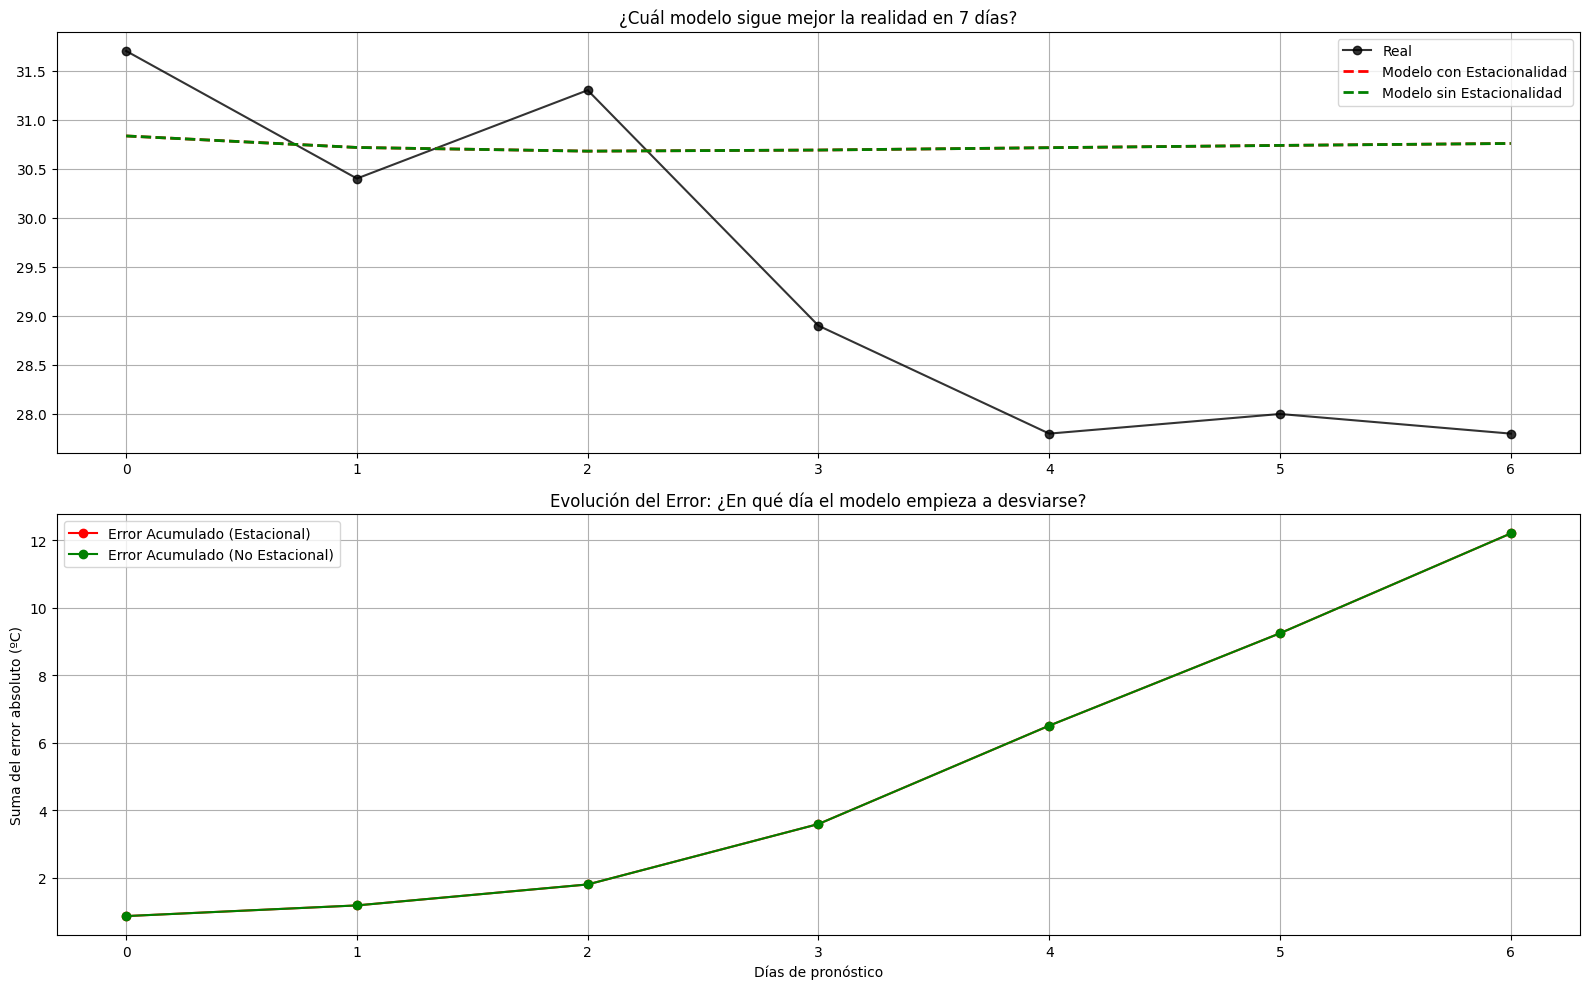

In [2]:
plt.figure(figsize=(16, 10))

# 1. Comparativa de Modelos
plt.subplot(2, 1, 1)
plt.plot(df_original['Temp_Maxima_C'].iloc[-7:].values, 'k-o', label='Real', alpha=0.8)
plt.plot(p7.values, 'r--', label='Modelo con Estacionalidad', linewidth=2)
plt.plot(p_no_s.values, 'g--', label='Modelo sin Estacionalidad', linewidth=2)
plt.title('¿Cuál modelo sigue mejor la realidad en 7 días?')
plt.legend()
plt.grid(True)

# 2. Curva de Error Acumulado
plt.subplot(2, 1, 2)

err_cum_s = np.cumsum(np.abs(df_original['Temp_Maxima_C'].iloc[-7:].values - p7.values))
err_cum_no_s = np.cumsum(np.abs(df_original['Temp_Maxima_C'].iloc[-7:].values - p_no_s.values))
plt.plot(err_cum_s, 'r-o', label='Error Acumulado (Estacional)')
plt.plot(err_cum_no_s, 'g-o', label='Error Acumulado (No Estacional)')
plt.title('Evolución del Error: ¿En qué día el modelo empieza a desviarse?')
plt.xlabel('Días de pronóstico')
plt.ylabel('Suma del error absoluto (ºC)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 📝 Conclusiones del Experimento de Sensibilidad

Tras evaluar el modelo **VARMAX (2, 1)** bajo distintas configuraciones de horizonte y estacionalidad, se determinan los siguientes hallazgos:

1. **Insensibilidad Estacional en Corto Plazo:**
   - Tanto el modelo con estacionalidad ($S=365$) como el modelo sin ella obtuvieron métricas idénticas (**MAE: 1.74 / MASE: 1.95**). 
   - **Interpretación:** En un horizonte de 7 días, el componente estacional anual no influye en la predicción. El modelo prioriza la inercia climática reciente (términos Auto-regresivos) sobre el patrón histórico de años anteriores.

2. **Análisis del Error (MAE de 1.74ºC):**
   - El error promedio de ~1.7ºC representa el "ruido blanco" o la variabilidad estocástica del clima local que no puede ser capturada únicamente con datos históricos de temperatura. 
   - Para mejorar esta métrica, sería necesario incluir variables exógenas (Humedad, Presión, Viento).

3. **El Desafío del MASE > 1:**
   - El hecho de que el modelo **Naive** (el de ayer) sea más preciso que el modelo estadístico confirma una **altísima persistencia térmica** en Pinar del Río. 
   - El clima es tan estable día a día que la técnica de "repetir el valor anterior" es un competidor estadístico muy fuerte, aunque carezca de capacidad para predecir cambios de tendencia.

4. **Veredicto de Implementación:**
   - Se recomienda utilizar el modelo **Sin Estacionalidad** para la puesta en producción. Es computacionalmente más ligero, más rápido de entrenar y ofrece la misma precisión para pronósticos semanales.